In [ ]:
# import pytesseract
# from PIL import Image, ImageDraw, ImageFont
# import numpy as np

# image = Image.open("/home/ankush.deshmukh/layout_based_classification/Train_data/aadhaar_back/0bf2d785-4ff2-4f73-8170-d530c1652df1-1.jpg")
# ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
# ocr_df = ocr_df.dropna().reset_index(drop=True)
# float_cols = ocr_df.select_dtypes('float').columns
# ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
# ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
# words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
# words


# pip install 'git+https://github.com/facebookresearch/detectron2.git'
# pip install ipywidgets
# pip install --upgrade jupyter
# pip install --upgrade tqdm
     

#encoded_inputs = processor(image, return_tensors="pt")

# for k,v in encoded_inputs.items():
#   print(k, v.shape)
#processor.tokenizer.decode(encoded_inputs.input_ids.squeeze().tolist())



Train - 21 classes, 100 samples each 
Test - 21 classes, 5-10 samples each

In [11]:
exp_folder_path = "/home/ankush.deshmukh/layout_based_classification/model_versions/" 
model_name = "model_feb_3_layoutlmv2_0.1"

import os

folder_path = exp_folder_path + model_name

if not os.path.exists(folder_path):
    # If not, create the folder
    os.makedirs(folder_path)
    print(f"Folder '{folder_path}' created.")
else:
    print(f"Folder '{folder_path}' already exists.")



dataset_path_train = "/home/ankush.deshmukh/layout_based_classification/Train_data"
dataset_path_test = "/home/ankush.deshmukh/layout_based_classification/Test_data"


Folder '/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_3_layoutlmv2_0.1' created.


In [12]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Returns True if CUDA is available, otherwise False
print(torch.version.cuda)

2.1.2+cu121
True
12.1


In [13]:
import os
import torch
import json
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import numpy as np
from datasets import Dataset 
from transformers import AdamW
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
from transformers import LayoutLMv2ForSequenceClassification
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2Tokenizer, LayoutLMv2Processor

def get_images_labels(dataset_path):
  images = []
  labels = []
  for label_folder, _, file_names in os.walk(dataset_path):
    if label_folder != dataset_path:
      label = label_folder.split("/")[-1]
      for _, _, image_names in os.walk(label_folder):
        relative_image_names = []
        for image_file in image_names:
          relative_image_names.append(dataset_path + "/" + label + "/" + image_file)
        images.extend(relative_image_names)
        labels.extend([label] * len (relative_image_names))
  return images, labels 


def print_counts(path):
    all_classes = os.listdir(path)
    count_dict = {}
    for class_name in all_classes:
        if class_name not in count_dict:
            count_dict[class_name] =  len(os.listdir(path+"/"+class_name))
    return count_dict

def id2label_label2id(path):
    labels = [label for label in os.listdir(path)]
    id2label = {v: k for v, k in enumerate(labels)}
    label2id = {k: v for v, k in enumerate(labels)}
    return id2label,label2id

# prepare image for the model
def predict_class(path,processor,model,id2label):
  image = Image.open(path)

  encoded_inputs = processor(image, return_tensors="pt")

  # make sure all keys of encoded_inputs are on the same device as the model
  for k,v in encoded_inputs.items():
    encoded_inputs[k] = v.to(model.device)

  # forward pass
  outputs = model(**encoded_inputs)

  logits = outputs.logits

  # Convert logits to probabilities using softmax
  probabilities = softmax(logits, dim=-1)
  
  predicted_class_idx = probabilities.argmax(-1).item()
  max_value, max_index = torch.max(probabilities, dim=-1)
  try:
    pred_class =id2label[predicted_class_idx]
  except:
    pred_class =id2label[str(predicted_class_idx)]
     

  print("Predicted class:", pred_class," confidence", max_value.tolist()[0])



def train_model(model, tokenizer,processor,id2label,label2id, dataloader_train, dataloader_test, num_train_epochs ,saving_path):
    tokenizer.save_pretrained(saving_path)
    processor.save_pretrained(saving_path)

    file_path = saving_path+"/"+"id2label.json"
    with open(file_path, 'w') as json_file:
        json.dump(id2label, json_file, indent=4)  # `indent=4` makes the JSON output readable

    file_path = saving_path+"/"+"label2id.json"
    # Open the file in write mode and save the dictionary as JSON
    with open(file_path, 'w') as json_file:
        json.dump(label2id, json_file, indent=4)  # `indent=4` makes the JSON output readable

    # Track metrics
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    best_val_accuracy = 0.0  # Track the best validation accuracy
    best_epoch = -1


    # Set optimizer
    #optimizer = AdamW(model.parameters(), lr=5e-5)
    optimizer = AdamW(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(num_train_epochs):
        print(f"Epoch {epoch + 1}/{num_train_epochs}")

        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels_train= []

        for batch in tqdm(dataloader_train):
            # Move the batch tensors to the correct device
            batch = {k: v.to(model.device) for k, v in batch.items()}
            optimizer.zero_grad()
            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss
            predictions = outputs.logits.argmax(-1)

            running_loss += loss.item()
            correct_train += (predictions == batch['labels']).float().sum()
            total_train += batch['labels'].size(0)
            all_labels_train.extend(batch['labels'].cpu().numpy())

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Compute training loss and accuracy
        train_loss = running_loss / len(dataloader_train)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy.item())

        print(f"Training Loss: {train_loss:.4f}")
        print(f"Training Accuracy: {train_accuracy.item():.2f}%")

        # --- Validation Phase ---
        model.eval()
        validation_loss = 0.0
        correct_val = 0
        total_val = 0

        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(dataloader_test):
                # Move the batch tensors to the correct device
                batch = {k: v.to(model.device) for k, v in batch.items()}

                # Forward pass (no gradients)
                outputs = model(**batch)
                loss = outputs.loss
                predictions = outputs.logits.argmax(-1)
                
                validation_loss += loss.item()
                correct_val += (predictions == batch['labels']).float().sum()
                total_val += batch['labels'].size(0)

                # Collect all predictions and labels for confusion matrix
                all_predictions.extend([id2label[pred] for pred in predictions.cpu().numpy()])
                all_labels.extend([id2label[label] for label in batch['labels'].cpu().numpy()])

        # Compute validation loss and accuracy
        val_loss = validation_loss / len(dataloader_test)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy.item())

        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Validation Accuracy: {val_accuracy.item():.2f}%")

        # Save the confusion matrix at best validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_epoch = epoch + 1

            # Save the confusion matrix
            cm = confusion_matrix(all_labels, all_predictions)
            plt.figure(figsize=(10, 7))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted((list(set(label2id.keys())))), yticklabels=sorted(list(set(label2id.keys()))))
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(saving_path, f"best_confusion_matrix.png"),dpi =300)
            plt.close()

            # Save model checkpoint when validation accuracy is the best
            model.save_pretrained(os.path.join(saving_path))
            print(f"Saved the model checkpoint for Epoch {best_epoch}")

        # Plotting after every epoch
        plt.figure(figsize=(12, 6))

        # Plot Training Loss and Validation Loss
        plt.subplot(1, 2, 1)
        plt.plot(range(epoch + 1), train_losses, label='Training Loss')
        plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Training Accuracy and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(range(epoch + 1), train_accuracies, label='Training Accuracy')
        plt.plot(range(epoch + 1), val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        # Save accuracy and loss metrics plot after each epoch
        plt.tight_layout()
        plt.savefig(os.path.join(saving_path, "acc_loss_metric.png"),dpi =300)
        plt.close()
    print(f"Best validation accuracy: {best_val_accuracy:.2f}% at Epoch {best_epoch}")
    
    return model
    

def load_the_model(loading_path):
  import json
  model = LayoutLMv2ForSequenceClassification.from_pretrained(loading_path)
  processor =  LayoutLMv2Processor.from_pretrained(loading_path)
  id2label = json.load(open(loading_path+"/"+"id2label.json"))
  label2id = json.load(open(loading_path+"/"+"label2id.json"))
  return model, processor, id2label, label2id

In [17]:
print(print_counts(dataset_path_train))
print(print_counts(dataset_path_test))


id2label,label2id = id2label_label2id(dataset_path_train)

images_train,labels_train = get_images_labels(dataset_path_train)
images_test,labels_test = get_images_labels(dataset_path_test)

data_train = pd.DataFrame.from_dict({'image_path': images_train, 'label': labels_train})
data_test = pd.DataFrame.from_dict({'image_path': images_test, 'label': labels_test})

unique_labels = list(set(labels_train))
dataset_train,dataset_test = Dataset.from_pandas(data_train),Dataset.from_pandas(data_test) 

# we need to define custom features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': ClassLabel(num_classes=len(unique_labels), names=unique_labels),
})

def preprocess_data(examples):
  # take a batch of images
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  encoded_inputs = processor(images, padding="max_length", truncation=True)
  # add labels
  encoded_inputs["labels"] = [label2id[label] for label in examples["label"]]
  return encoded_inputs


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LayoutLMv2ForSequenceClassification.from_pretrained("microsoft/layoutlmv2-base-uncased", num_labels=len(list(set(labels_train))))
model.to(device)

feature_extractor = LayoutLMv2FeatureExtractor()
tokenizer = LayoutLMv2Tokenizer.from_pretrained("microsoft/layoutlmv2-base-uncased")
processor= LayoutLMv2Processor(feature_extractor, tokenizer)


encoded_dataset_train = dataset_train.map(preprocess_data, remove_columns=dataset_train.column_names, batched=True, batch_size=64,num_proc = 25)
encoded_dataset_test = dataset_test.map(preprocess_data, remove_columns=dataset_test.column_names,  batched=True, batch_size=64,num_proc = 25)
encoded_dataset_train.set_format(type="torch", device="cuda")
encoded_dataset_test.set_format(type="torch", device="cuda")


dataloader_train = torch.utils.data.DataLoader(encoded_dataset_train, batch_size=16,shuffle =True)
dataloader_test = torch.utils.data.DataLoader(encoded_dataset_test, batch_size=16)


{'photograph': 100, 'passport_back': 100, 'cheques': 100, 'voter_back': 100, 'DL': 100, 'mri_report': 100, 'voter_front': 100, 'aadhaar_full': 100, 'passbook': 100, 'cowin': 100, 'usg_report': 100, 'aadhaar_front': 100, 'payslip': 100, 'passport_front': 100, 'pan': 100, 'aadhaar_back': 100, 'itr': 100, 'angiogram': 100, 'death_certificate': 100, 'birth_certificate': 100, 'xray_report': 100}
{'photograph': 10, 'passport_back': 10, 'cheques': 10, 'voter_back': 10, 'DL': 10, 'mri_report': 5, 'voter_front': 10, 'aadhaar_full': 10, 'passbook': 10, 'cowin': 10, 'usg_report': 5, 'aadhaar_front': 10, 'payslip': 10, 'passport_front': 10, 'pan': 10, 'aadhaar_back': 10, 'itr': 10, 'angiogram': 10, 'death_certificate': 10, 'birth_certificate': 10, 'xray_report': 5}


Some weights of LayoutLMv2ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv2-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


Map (num_proc=25):   0%|          | 0/2100 [00:00<?, ? examples/s]

/home/ankush.deshmukh/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (123748730 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/ankush.deshmukh/.local/lib/python3.10/site-packages/PIL/Image.py:3182: DecompressionBombWarning: Image size (100155852 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Map (num_proc=25):   0%|          | 0/195 [00:00<?, ? examples/s]

In [18]:
saving_path = exp_folder_path + model_name
num_train_epochs = 50
model = train_model(model, tokenizer,processor,id2label,label2id, dataloader_train, dataloader_test, num_train_epochs ,saving_path)

/home/ankush.deshmukh/.local/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/50


100%|██████████| 132/132 [05:13<00:00,  2.38s/it]


Training Loss: 2.0100
Training Accuracy: 41.38%


100%|██████████| 13/13 [00:08<00:00,  1.49it/s]


Validation Loss: 1.7121
Validation Accuracy: 53.33%
Saved the model checkpoint for Epoch 1
Epoch 2/50


100%|██████████| 132/132 [05:12<00:00,  2.37s/it]


Training Loss: 1.0902
Training Accuracy: 69.71%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 1.0107
Validation Accuracy: 69.23%
Saved the model checkpoint for Epoch 2
Epoch 3/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.6278
Training Accuracy: 83.19%


100%|██████████| 13/13 [00:08<00:00,  1.50it/s]


Validation Loss: 0.8512
Validation Accuracy: 70.77%
Saved the model checkpoint for Epoch 3
Epoch 4/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 1.3954
Training Accuracy: 55.90%


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Validation Loss: 1.2489
Validation Accuracy: 55.90%
Epoch 5/50


100%|██████████| 132/132 [05:10<00:00,  2.35s/it]


Training Loss: 0.7966
Training Accuracy: 75.62%


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Validation Loss: 0.9702
Validation Accuracy: 67.18%
Epoch 6/50


100%|██████████| 132/132 [05:10<00:00,  2.36s/it]


Training Loss: 0.5626
Training Accuracy: 82.33%


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Validation Loss: 0.9169
Validation Accuracy: 68.72%
Epoch 7/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.4222
Training Accuracy: 86.67%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.6182
Validation Accuracy: 78.97%
Saved the model checkpoint for Epoch 7
Epoch 8/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.3008
Training Accuracy: 90.33%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.6329
Validation Accuracy: 81.03%
Saved the model checkpoint for Epoch 8
Epoch 9/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.2256
Training Accuracy: 92.43%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.5923
Validation Accuracy: 81.54%
Saved the model checkpoint for Epoch 9
Epoch 10/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.1810
Training Accuracy: 93.33%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.8601
Validation Accuracy: 74.36%
Epoch 11/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.1532
Training Accuracy: 95.14%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.5878
Validation Accuracy: 80.51%
Epoch 12/50


100%|██████████| 132/132 [05:10<00:00,  2.36s/it]


Training Loss: 0.1263
Training Accuracy: 95.76%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.4940
Validation Accuracy: 85.13%
Saved the model checkpoint for Epoch 12
Epoch 13/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.2034
Training Accuracy: 93.14%


100%|██████████| 13/13 [00:08<00:00,  1.51it/s]


Validation Loss: 0.5795
Validation Accuracy: 81.54%
Epoch 14/50


100%|██████████| 132/132 [05:11<00:00,  2.36s/it]


Training Loss: 0.1750
Training Accuracy: 94.76%


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Validation Loss: 0.5258
Validation Accuracy: 82.56%
Epoch 15/50


100%|██████████| 132/132 [05:10<00:00,  2.35s/it]


Training Loss: 0.0940
Training Accuracy: 97.29%


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


Validation Loss: 0.5677
Validation Accuracy: 81.54%
Epoch 16/50


 19%|█▉        | 25/132 [00:58<04:12,  2.36s/it]


KeyboardInterrupt: 

In [21]:
path = "/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_2_0.2"
loaded_model,loaded_processor,loaded_id2label, loaded_label2id = load_the_model(path)
img_path ="/home/ankush.deshmukh/image_classification/dummy_test_set/pan/0d7a8320-ccd3-4e9b-b07b-4c821cd9e1db-1.jpg"
predict_class(img_path,loaded_processor,loaded_model,loaded_id2label)

Predicted class: itr  confidence 0.05767662823200226


100%|██████████| 13/13 [00:08<00:00,  1.52it/s]


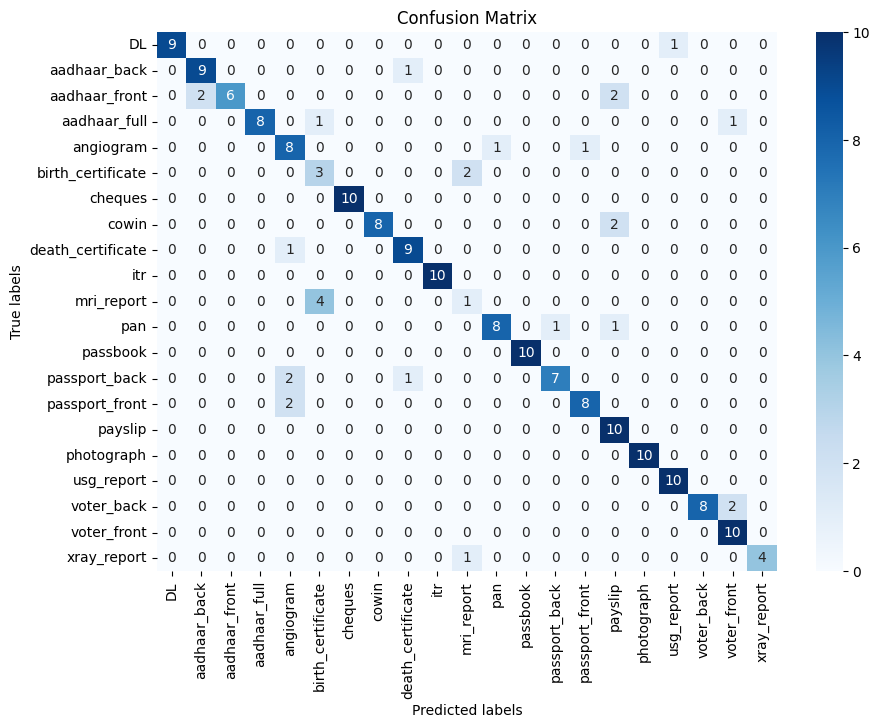

In [19]:
import torch
from transformers import LayoutLMv2ForSequenceClassification, LayoutLMv2Processor
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
path = "/home/ankush.deshmukh/layout_based_classification/model_versions/model_feb_3_layoutlmv2_0.1"
loaded_model,loaded_processor,loaded_id2label, loaded_label2id  = load_the_model(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
unique_labels = list(label2id.keys())
# Put the model in evaluation mode
model.eval()

# Initialize the DataLoader for the test dataset
# Assuming your test dataset is in 'dataloader_test'
all_predictions = []
all_labels = []

# Inference on the test dataset
with torch.no_grad():  # Disable gradient calculation during inference
    for batch in tqdm(dataloader_test):
        # Forward pass (inference)
        outputs = model(**batch)
        
        # Get the predicted class (with highest logits)
        predictions = outputs.logits.argmax(-1)
        
        # Store predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(unique_labels), yticklabels=sorted(unique_labels))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
#plt.savefig("/home/ankush.deshmukh/layout_based_classification/metric/feb_1_confusion_matrix.png")  # Save the confusion matrix as an image
plt.show()  # Optionally show the plot

#print("Confusion matrix saved as 'confusion_matrix.png'.")
